<a href="https://colab.research.google.com/github/emma2763/Machine-Learning/blob/main/my2763_5074_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Report on Covid Positive X-Ray Image Data**

Github link:

Citation of paper providing original dataset:  M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145

# Import Data and Train Test Split

In [ ]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [ ]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/5074/covid_radiography_data/COVID-19_Radiography_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
 

In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-221.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1705.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3206.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3349.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2621.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2859.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1964.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3042.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2603.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3099.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2094.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-91.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1581.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1412.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2752.png', 'COVID-19_Radiography_Dataset/COVID/images/CO

In [ ]:
#Reduce number of images to first 1345 for each category -> smaller and balanced data
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img

#Try on single x-ray file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function 
# (map functions apply your preprocessor function one step at a time to each filepath)
preprocessed_image_data=list(map(preprocessor,image_filepaths))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
len(image_filepaths)

4032

In [ ]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one

4032
(4032, 192, 192, 3)
-0.0
1.0


In [ ]:
len(fnames[2])

1344

In [ ]:
# Create y data made up of correctly ordered labels from file folders

from itertools import repeat

print('number of images for each category:', [len(f) for f in fnames])

covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras. Let's use Pandas
import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


COVID  NORMAL  PNEUMONIA
0         1       0          0
1         1       0          0
2         1       0          0
3         1       0          0
4         1       0          0
...     ...     ...        ...
4027      0       0          1
4028      0       0          1
4029      0       0          1
4030      0       0          1
4031      0       0          1

[4032 rows x 3 columns]

## Train test split

In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)

X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

## Save Data

In [ ]:
##Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime

import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)

with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [ ]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [ ]:
##If you run out of Colab memory restart runtime, reload data and try again
import pickle
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

# Image Visualization

Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not (You can present visuals of each category in the data if you would like to.).

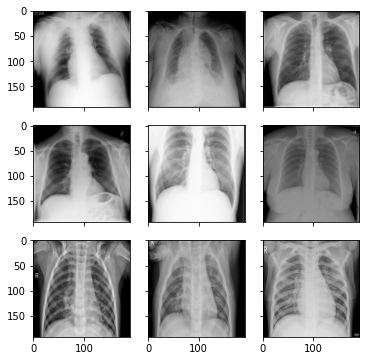

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[0][2])
im4 =preprocessor(fnames[1][0])
im5 =preprocessor(fnames[1][1])
im6 =preprocessor(fnames[1][2])
im7 =preprocessor(fnames[2][0])
im8 =preprocessor(fnames[2][1])
im9 =preprocessor(fnames[2][2])

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 3x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6, im7, im8, im9]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

The first row are COVID positive chest X-ray images. The second row are NORMAL chest X-ray images with no lung infection. The thrid row are images of non-COVID VIRAL PNEUMONIA.

## Discussion

Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful. Who could benefit from a model like this? Explain.

<font color = navy> The dataset contains images of three categories: Normal, Covid-19 positive, and non-covid viral pneumonia. Even from a non-medical point of view, we can easily tell that there is difference between normal lung and infected lung. Thus, if algorithm can be trained to predict COVID using X-ray images with high accuracy, then it provides a quick, cheap but effective and efficient way for diagnosis of COVID. Moreover, COVID images and non-covid viral pneumonia images have many similarities that it is difficult to tell the difference from eye-balling except for experienced doctors. Deep learning networks, hopefully, can learn the differences and tell aprt COVID from VIRAL PNEUMONIA. It would help to detect, treat and prevent COVID, especially in areas where PCR tests are too expensive and lack of medical personnel. 

# Run Prediction Models

Run at least three prediction models to try to predict x-ray images well.
Use transfer learning for at least one of these models.

## Model 1

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                    

In [ ]:
model.compile(
    optimizer="adam",
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
# Fitting the CNN to the Training set
model.fit(X_train, y_train, 
                    epochs = 1, verbose=1, validation_split=.2)

69/69 [==============================] - 392s 6s/step - loss: 0.8149 - accuracy: 0.6013 - val_loss: 0.6123 - val_accuracy: 0.7086


In [ ]:
model.save("model1.h5", save_format="h5")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 2 with callbacks

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                    

In [ ]:
model.compile(
    optimizer= Adam(learning_rate=0.001),
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
# Fitting the CNN to the Training set
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

model.fit(X_train, y_train, 
          epochs = 1, verbose=1, callbacks=[red_lr], validation_split=.2)

69/69 [==============================] - ETA: 0s - loss: 0.8208 - accuracy: 0.5826

69/69 [==============================] - 611s 9s/step - loss: 0.8208 - accuracy: 0.5826 - val_loss: 0.5927 - val_accuracy: 0.7377 - lr: 0.0010


In [ ]:
model.save("model2.h5", save_format="h5")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 3 my VGG16

In [ ]:
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

 model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 128)      0         
 2D)                                                    

In [ ]:
model.compile(
    optimizer="adam",
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
# Fitting the CNN to the Training set
model.fit(X_train, y_train, epochs = 1, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

69/69 [==============================] - 4692s 68s/step - loss: 1.2513 - accuracy: 0.3380 - val_loss: 1.0988 - val_accuracy: 0.3406


In [ ]:
model.save("model3.h5", save_format="h5")

## Model 4 VGG19

In [ ]:
# Create the base model from the pre-trained model VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

base_model = VGG19(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

In [ ]:
# Freeze the weights of the VGG19 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False
base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
class2 = Dense(256, activation='relu')(class1)
class3 = Dense(128, activation='relu')(class2)
output = Dense(3, activation='softmax')(class3)

# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
# Fit VGG19 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 1, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

2192/2192 [==============================] - ETA: 0s - loss: 0.5929 - acc: 0.7911
Epoch 00001: val_acc improved from -inf to 0.84335, saving model to best_model.h5
2192/2192 [==============================] - 1924s 877ms/step - loss: 0.5929 - acc: 0.7911 - val_loss: 0.4199 - val_acc: 0.8434 - lr: 0.0010


In [ ]:
model.save("model4.h5", save_format="h5")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

## Model 5 ResNet50

In [ ]:
# load model new input layer shape.
IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [ ]:
# Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 96, 96, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input

# Getting output tensor of the last ResNet layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
from tensorflow.keras.layers import GlobalAveragePooling2D
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
class1 = Dense(512, activation='relu')(gap1)
class2 = Dense(256, activation='relu')(class1)
class3 = Dense(128, activation='relu')(class2)
output = Dense(3, activation='softmax')(class3)

# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 96, 96, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
# Fit Resnet model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint

  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 1, verbose=1, validation_split=.2, callbacks=[mc,red_lr])

2192/2192 [==============================] - ETA: 0s - loss: 1.1081 - acc: 0.3289
Epoch 00001: val_acc improved from -inf to 0.33880, saving model to best_model.h5
2192/2192 [==============================] - 521s 236ms/step - loss: 1.1081 - acc: 0.3289 - val_loss: 1.0992 - val_acc: 0.3388 - lr: 0.0010


In [ ]:
model.save("model5.h5", save_format="h5")

## Model 6 InceptionV3

In [ ]:
# load model new input layer shape.
IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model InceptionV3
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                      

In [ ]:
# Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False
base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
from tensorflow.keras.layers import GlobalAveragePooling2D
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
class1 = Dense(512, activation='relu')(gap1)
class2 = Dense(256, activation='relu')(class1)
class3 = Dense(128, activation='relu')(class2)
output = Dense(3, activation='softmax')(class3)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [ ]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint

  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 1, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

2192/2192 [==============================] - ETA: 0s - loss: 0.6755 - acc: 0.7231
Epoch 00001: val_acc improved from -inf to 0.81239, saving model to best_model.h5
2192/2192 [==============================] - 394s 177ms/step - loss: 0.6755 - acc: 0.7231 - val_loss: 0.4316 - val_acc: 0.8124 - lr: 0.0010


In [ ]:
model.save("model6.h5", save_format="h5")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Discussion

Discuss which models performed better and point out relevant hyper-parameter values for successful models.

<font color = navy> In model 1, I train a toy shallow CNN which performs not badly I would say since it has only several layers and one epoch. Model 2 uses callbacks to reduce learning rate when validation accuracy fails to improve, which improves model prediction performance slightly. I also try to train a VGG16 model (Model 3) by myself. It took over one hour to fit model and the model performed very poorly in prediction accuracy, which was not surprising because of constraints in computing power and dataset size. Transfer Learning models, which utilized weights that had already well learnt from large amount of images, performed quite well. Both VGG19 and InceptionV3 achieved accuracy of over 0.81. At first I only added one dense layer of 112 nodes, which was not very satisfying. The models performed better after adding more layers to base models. I also experimented with optimizer and callbacks of learning rates. However, ResNet50 performed poorly and I need to take a closer look.

## Submit Models

Submit your best three models to the leader board for the Covid X-ray Diagnostic AI Model Share competition.

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
#Restart session Runtime > Restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.8/967.8 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 KB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13

### Model 1

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5',compile=False)
model.compile(
    optimizer="adam",
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                    

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fc689ac75e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 68s 2s/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 119

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

### Model 2 VGG19

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model4.h5',compile=False)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fe674cf3700>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 851s 21s/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 131

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

### Model 3 InceptionV3

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model6.h5',compile=False)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f102cacb5e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 134s 3s/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 132

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

# After Teamwork

Fit and submit up to three more models after learning from your team.

## Model 1

### VGG19 with L2 regularization, batch normalization, and 2 epochs

In [ ]:
# Create the base model from the pre-trained model VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

base_model = VGG19(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

In [ ]:
# Freeze the weights of the VGG19 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False
base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

from tensorflow.keras.layers import BatchNormalization

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(512, activation='relu', kernel_regularizer= regularizers.L2(l2=0.05))(flat1)
BatchNormalization(),
class2 = Dense(256, activation='relu', kernel_regularizer= regularizers.L2(l2=0.05))(class1)
BatchNormalization(),
class3 = Dense(128, activation='relu', kernel_regularizer= regularizers.L2(l2=0.05))(class2)
BatchNormalization(),
output = Dense(3, activation='softmax', kernel_regularizer= regularizers.L2(l2=0.05))(class3)

# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0   

In [ ]:
# Fit VGG19 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc']) 

  model.fit(X_train, y_train, batch_size=1,
          epochs = 2, verbose=1, validation_split=.2, callbacks=[mc,red_lr])

Epoch 1/2
2192/2192 [==============================] - ETA: 0s - loss: 2.6729 - acc: 0.5849
Epoch 00001: val_acc improved from -inf to 0.63934, saving model to best_model.h5
2192/2192 [==============================] - 2227s 1s/step - loss: 2.6729 - acc: 0.5849 - val_loss: 0.9046 - val_acc: 0.6393 - lr: 0.0010
Epoch 2/2
2192/2192 [==============================] - ETA: 0s - loss: 0.9009 - acc: 0.6141
Epoch 00002: val_acc did not improve from 0.63934
2192/2192 [==============================] - 2170s 990ms/step - loss: 0.9009 - acc: 0.6141 - val_loss: 0.9410 - val_acc: 0.5228 - lr: 0.0010


In [ ]:
model.save("model7.h5", save_format="h5")

### Submit model

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
#Restart session Runtime > Restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model7.h5',compile=False)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0   

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)
from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

In [ ]:
# Submit to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

41/41 [==============================] - 861s 21s/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 133

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

## Model 2

### InceptionV3 with 2 epochs

In [ ]:
# load model new input layer shape.
IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model InceptionV3
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
# Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False
base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
from tensorflow.keras.layers import GlobalAveragePooling2D
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
class1 = Dense(512, activation='relu')(gap1)
class2 = Dense(256, activation='relu')(class1)
class3 = Dense(128, activation='relu')(class2)
output = Dense(3, activation='softmax')(class3)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint

  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 2, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

Epoch 1/2
2192/2192 [==============================] - ETA: 0s - loss: 0.6334 - acc: 0.7464
Epoch 00001: val_acc improved from -inf to 0.79417, saving model to best_model.h5
2192/2192 [==============================] - 421s 189ms/step - loss: 0.6334 - acc: 0.7464 - val_loss: 0.4845 - val_acc: 0.7942 - lr: 0.0010
Epoch 2/2
2192/2192 [==============================] - ETA: 0s - loss: 0.4407 - acc: 0.8130
Epoch 00002: val_acc improved from 0.79417 to 0.83971, saving model to best_model.h5
2192/2192 [==============================] - 382s 174ms/step - loss: 0.4407 - acc: 0.8130 - val_loss: 0.4248 - val_acc: 0.8397 - lr: 0.0010


In [ ]:
model.save("model8.h5", save_format="h5")

### Submit model

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
#Restart session Runtime > Restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model8.h5',compile=False)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 135s 3s/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 134

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

## Model 3

### InceptionV3 with L2 regularization, batch normalization

In [ ]:
# load model new input layer shape.
IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model InceptionV3
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
# Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False
base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
from tensorflow.keras.layers import GlobalAveragePooling2D
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
class1 = Dense(512, activation='relu', kernel_regularizer= regularizers.L2(l2=0.05))(gap1)
BatchNormalization()
class2 = Dense(256, activation='relu', kernel_regularizer= regularizers.L2(l2=0.05))(class1)
BatchNormalization()
class3 = Dense(128, activation='relu', kernel_regularizer= regularizers.L2(l2=0.05))(class2)
BatchNormalization()
output = Dense(3, activation='softmax', kernel_regularizer= regularizers.L2(l2=0.05))(class3)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint

  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 1, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

2192/2192 [==============================] - ETA: 0s - loss: 2.9182 - acc: 0.6455
Epoch 00001: val_acc improved from -inf to 0.63934, saving model to best_model.h5
2192/2192 [==============================] - 503s 222ms/step - loss: 2.9182 - acc: 0.6455 - val_loss: 0.9112 - val_acc: 0.6393 - lr: 0.0010


In [ ]:
model.save("model9.h5", save_format="h5")

### Submit model

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
#Restart session Runtime > Restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model9.h5',compile=False)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission
#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 136s 3s/step


In [ ]:
# Submit to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 135

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

## Discussion

<font color = navy> Some of my teammate mentioned increasing the number of epochs improved model performance. First, I tried VGG19 with 2 epochs as well as L2 regularization and batch normalization. But it seemed to lead to overfitting and prediction accuracy was just 0.52. Then I experimented with InceptionV3 and 2 epoches, which imcreased accuracy from 0.81 to 0.83. Finally, I trained InceptionV3 with L2 regularization and batch normalization. Accuracy was 0.63, worse than original InceptionV3 model.

# Data Augmentation

Try to use augmented data to rerun at least one model and submit it to the leaderboard.

## Model 1 


### Rotate 25 degree

In [ ]:
# load images from the original list of filenames, but not preprocess
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

filenamelist=fnames[0]+fnames[1]+fnames[2]
len(filenamelist)

4032

In [ ]:
# Create y data made up of correctly ordered labels from file folders

from itertools import repeat

print('number of images for each category:', [len(f) for f in fnames])

covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas
import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


COVID  NORMAL  PNEUMONIA
0         1       0          0
1         1       0          0
2         1       0          0
3         1       0          0
4         1       0          0
...     ...     ...        ...
4027      0       0          1
4028      0       0          1
4029      0       0          1
4030      0       0          1
4031      0       0          1

[4032 rows x 3 columns]

In [ ]:
# Train test split file names and labels
from sklearn.model_selection import train_test_split

X_train_datagen,X_test_datagen,y_train_datagen,y_test_datagen=train_test_split(filenamelist,y_labels,test_size=0.32,random_state=1987)

print(X_train_datagen[0:5])
y_train_datagen[0:5] 

['COVID-19_Radiography_Dataset/Normal/images/Normal-8063.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-789.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1245.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1842.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-394.png']


['NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'COVID', 'COVID']

In [ ]:
import pandas as pd
trainingdata=pd.DataFrame.from_dict({'X': X_train_datagen, 'y': y_train_datagen})
testdata=pd.DataFrame.from_dict({'X': X_test_datagen, 'y': y_test_datagen})

trainingdata.head()

X          y
0  COVID-19_Radiography_Dataset/Normal/images/Nor...     NORMAL
1  COVID-19_Radiography_Dataset/Viral Pneumonia/i...  PNEUMONIA
2  COVID-19_Radiography_Dataset/Viral Pneumonia/i...  PNEUMONIA
3  COVID-19_Radiography_Dataset/COVID/images/COVI...      COVID
4  COVID-19_Radiography_Dataset/COVID/images/COVI...      COVID

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainingdata,
        directory=None,
        x_col="X", # Actual column names from data
        y_col="y",
        target_size=(192, 192),
        batch_size=1,
        class_mode='categorical',shuffle=True)

Found 2741 validated image filenames belonging to 3 classes.


In [ ]:
validation_generator = test_datagen.flow_from_dataframe(
        dataframe=testdata,
        directory=None,
        x_col="X",
        y_col="y",
        target_size=(192, 192),
        batch_size=1,
        class_mode='categorical')

Found 1291 validated image filenames belonging to 3 classes.


### Train InceptionV3

In [ ]:
# load model new input layer shape.
IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model InceptionV3
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
# Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False
base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
from tensorflow.keras.layers import GlobalAveragePooling2D
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
class1 = Dense(512, activation='relu')(gap1)
class2 = Dense(256, activation='relu')(class1)
class3 = Dense(128, activation='relu')(class2)
output = Dense(3, activation='softmax')(class3)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint

  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc']) 

  model.fit(train_generator, validation_data=validation_generator, batch_size=1, 
          epochs = 1, verbose=1, validation_split=.2, callbacks=[mc,red_lr])

2741/2741 [==============================] - ETA: 0s - loss: 0.6301 - acc: 0.7304
Epoch 00001: val_acc improved from -inf to 0.81022, saving model to best_model.h5
2741/2741 [==============================] - 734s 265ms/step - loss: 0.6301 - acc: 0.7304 - val_loss: 0.4082 - val_acc: 0.8102 - lr: 0.0010


In [ ]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint

  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc']) 

  model.fit(train_generator, validation_data=validation_generator, batch_size=1, 
          epochs = 1, verbose=1, callbacks=[mc,red_lr])

In [ ]:
model.save("model10.h5", save_format="h5")

### Submit model

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
#Restart session Runtime > Restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model10.h5',compile=False)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
prediction_column_index=model.predict(train_generator).argmax(axis=1)

2741/2741 [==============================] - 462s 169ms/step


In [ ]:
# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

In [ ]:
#prediction_column_index[1]

2

In [ ]:
#train_generator[y]

ValueError: ignored

In [ ]:
#prediction_labels = [train_generator[y][i] for i in prediction_column_index]

In [ ]:
# Submit to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 148

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

## Model 2 

### Zoom & Flip

In [ ]:
# load images from the original list of filenames, but not preprocess
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

filenamelist=fnames[0]+fnames[1]+fnames[2]
len(filenamelist)

4032

In [ ]:
# Create y data made up of correctly ordered labels from file folders

from itertools import repeat

print('number of images for each category:', [len(f) for f in fnames])

covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas
import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


COVID  NORMAL  PNEUMONIA
0         1       0          0
1         1       0          0
2         1       0          0
3         1       0          0
4         1       0          0
...     ...     ...        ...
4027      0       0          1
4028      0       0          1
4029      0       0          1
4030      0       0          1
4031      0       0          1

[4032 rows x 3 columns]

In [ ]:
# Train test split file names and labels
from sklearn.model_selection import train_test_split

X_train_datagen,X_test_datagen,y_train_datagen,y_test_datagen=train_test_split(filenamelist,y_labels,test_size=0.32,random_state=1987)

print(X_train_datagen[0:5])
y_train_datagen[0:5] 

['COVID-19_Radiography_Dataset/Normal/images/Normal-1140.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-859.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-395.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2707.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-957.png']


['NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'COVID', 'COVID']

In [ ]:
import pandas as pd
trainingdata=pd.DataFrame.from_dict({'X': X_train_datagen, 'y': y_train_datagen})
testdata=pd.DataFrame.from_dict({'X': X_test_datagen, 'y': y_test_datagen})

trainingdata.head()

X          y
0  COVID-19_Radiography_Dataset/Normal/images/Nor...     NORMAL
1  COVID-19_Radiography_Dataset/Viral Pneumonia/i...  PNEUMONIA
2  COVID-19_Radiography_Dataset/Viral Pneumonia/i...  PNEUMONIA
3  COVID-19_Radiography_Dataset/COVID/images/COVI...      COVID
4  COVID-19_Radiography_Dataset/COVID/images/COVI...      COVID

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.5,

        horizontal_flip=True,
        vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainingdata,
        directory=None,
        x_col="X", # Actual column names from data
        y_col="y",
        target_size=(192, 192),
        batch_size=1,
        class_mode='categorical',shuffle=True)

Found 2741 validated image filenames belonging to 3 classes.


In [ ]:
validation_generator = test_datagen.flow_from_dataframe(
        dataframe=testdata,
        directory=None,
        x_col="X",
        y_col="y",
        target_size=(192, 192),
        batch_size=1,
        class_mode='categorical')

Found 1291 validated image filenames belonging to 3 classes.


### Train InceptionV3

In [ ]:
# load model new input layer shape.
IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model InceptionV3
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 95, 95, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 95, 95, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [ ]:
# Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False
base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 95, 95, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 95, 95, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
from tensorflow.keras.layers import GlobalAveragePooling2D
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
class1 = Dense(512, activation='relu')(gap1)
class2 = Dense(256, activation='relu')(class1)
class3 = Dense(128, activation='relu')(class2)
output = Dense(3, activation='softmax')(class3)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 95, 95, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 95, 95, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [ ]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint

  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc']) 

  model.fit(train_generator, validation_data=validation_generator, batch_size=1, 
          epochs = 1, verbose=1, callbacks=[mc,red_lr])

2741/2741 [==============================] - ETA: 0s - loss: 0.7263 - acc: 0.6950
Epoch 00001: val_acc improved from -inf to 0.78079, saving model to best_model.h5
2741/2741 [==============================] - 702s 253ms/step - loss: 0.7263 - acc: 0.6950 - val_loss: 0.5652 - val_acc: 0.7808 - lr: 0.0010


In [ ]:
model.save("model11.h5", save_format="h5")

### Submit model

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
#Restart session Runtime > Restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model11.h5',compile=False)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 95, 95, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 95, 95, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
prediction_column_index=model.predict(train_generator).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

2741/2741 [==============================] - 424s 155ms/step


In [ ]:
# Submit to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 140

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

## Discussion

<font color = navy>I rerun InceptionV3 model on augmented data by two methods. One is rorating 25 degree. The other is zooming up to 50% as well as horizontal and vertical flips. Unfortunately, I do not see improvement in model performance. The reason may be that the original dateset I used is already balanced and the size is not too small.

# Final Discussion

Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.

<font color = navy> In summary, Transfer Learning using InceptionV3 with 2 epochs performed best. I add one GlobalAveragePooling2D layer and three dense layers(512, 256, and 128) to base model before output layer. 'Adam' optimizaer and callbacks are used. L2 regularization, batch normalization, and data augmentation does not improve model performance.